In [2]:
import pandas as pd

from benchmark._plot_util import *

In [3]:
file = "qaoa_cost.csv"

df_qaoa = pd.read_csv(file)
df_qaoa = df_qaoa[df_qaoa["m"] == 2]
# df.drop(columns=["m"], inplace=True)

df1 = df_qaoa[df_qaoa["name"] == "qaoa1"].copy()
df1["num_qubits"] = df1["r"] * df1["n"] + df1["m"] * (df1["r"] - 1)
df1.drop(columns=["r", "n", "m"], inplace=True)

df2 = df_qaoa[df_qaoa["name"] == "qaoa2"].copy()
df2["num_qubits"] = df2["r"] * df2["n"]
df2.drop(columns=["r", "n", "m"], inplace=True)


df_qaoa = pd.concat([df1, df2])


In [4]:
def postprocess(ax):
    hatches = ["**", "//"]

    color_to_hatch = {}

    i = 0
    for patch in ax.patches:
        if patch.get_facecolor() not in color_to_hatch:
            color_to_hatch[patch.get_facecolor()] = hatches[i % len(hatches)]
            i += 1

    for patch in ax.patches:
        patch.set_hatch(color_to_hatch[patch.get_facecolor()])

In [5]:
def plot(df, ax):

    # df = df[df["reps"] == 1]
    df = df[df["ckt_cost"] > 0]
    df = df[["num_qubits", "qtpu_cost", "ckt_cost"]]
    # print(df)
    # rename columns
    df = df.rename(columns={"ckt_cost": "CKT", "qtpu_cost": "QTPU"})

    df.sort_index()
    df_mean = df.groupby(["num_qubits"]).mean()
    df_std = df.groupby(["num_qubits"]).std().reset_index()
    # .drop("name", axis=1)

    df_mean.plot.bar(
        rot=0,
        width=0.8,
        edgecolor="black",
        linewidth=2,
        ax=ax,
        legend=False,
        yerr=df_std.to_numpy().T,
    )

    postprocess(ax)

    ax.set_yscale("log")
    # ax.set_yticklabels([f"$10^{{{int(x.get_text())}}}$" for x in ax.get_yticklabels()])
    # ax.set_title("Lower is better ↓", fontweight="bold", color="midnightblue")
    ax.set_xlabel("")
    ax.set_ylabel("Contraction Cost [FLOPs]")

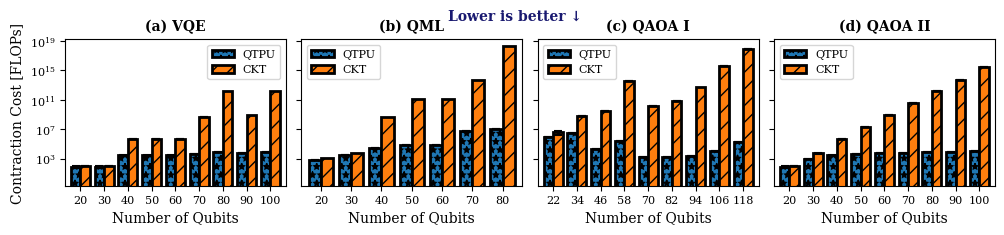

In [32]:
df_standard = pd.read_csv("cost_standard.csv")
df45 = pd.concat([df_standard, df_qaoa])


titles = ["VQE", "QML", "QAOA I", "QAOA II"]
dfs = [
    df45[df45["name"] == "linear"].copy(),
    df45[df45["name"] == "zz"].copy(),
    df45[df45["name"] == "qaoa1"].copy(),
    df45[df45["name"] == "qaoa2"].copy(),
]

# for df in dfs:
    # print(df)


fig, axes = plt.subplots(1, len(dfs), figsize=(12, 1.9), sharey=True)
fig.subplots_adjust(wspace=0.07)  # adjust padding between subplots



for i, (title, df, ax) in enumerate(zip(titles, dfs, axes)):
    plot(df, ax)
    ax.legend()
    ax.set_title(f"({str(chr(97 + i))}) {title}", fontweight="bold", color="black")
    ax.set_xlabel("Number of Qubits")

# put text on the top with "Lower is better"
fig.text(0.5, 1, "Lower is better ↓", ha='center', va='center', fontweight="bold", color="midnightblue")
# put tighter distance between plots

# fig.tight_layout(pad=1.0)


fig;

In [33]:
fig.savefig("cost.pdf", bbox_inches="tight")